In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [12]:
from google.colab import files
uploaded = files.upload()

Saving Detectron2.zip to Detectron2.zip


In [13]:
!unzip Detectron2.zip

Archive:  Detectron2.zip
   creating: Detectron2/
   creating: Detectron2/test/
  inflating: Detectron2/test/0009.jpg  
  inflating: Detectron2/test/0009.xml  
  inflating: Detectron2/test/0036.jpg  
  inflating: Detectron2/test/0039.jpg  
  inflating: Detectron2/test/0039.xml  
  inflating: Detectron2/test/0042.jpg  
  inflating: Detectron2/test/0044.jpg  
  inflating: Detectron2/test/0045.jpg  
  inflating: Detectron2/test/0048.jpg  
  inflating: Detectron2/test/0049.jpg  
  inflating: Detectron2/test/0051.jpg  
  inflating: Detectron2/test/0055.jpg  
  inflating: Detectron2/test/0058.jpg  
  inflating: Detectron2/test/0063.jpg  
  inflating: Detectron2/test/0067.jpg  
  inflating: Detectron2/test/0070.jpg  
  inflating: Detectron2/test/0075.jpg  
  inflating: Detectron2/test/0076.jpg  
  inflating: Detectron2/test/0077.jpg  
  inflating: Detectron2/test/0080.jpg  
  inflating: Detectron2/test/0082.jpg  
  inflating: Detectron2/test/0084.jpg  
  inflating: Detectron2/test/0088.jpg  


In [4]:
!ls

'=2.0.1'   Detectron2   Detectron21   Detectron2.zip   output   sample_data


In [5]:
import pandas as pd

df = pd.read_csv('Detectron2/train_labels.csv')

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0007.jpg,400,300,Canada flag,153,122,245,180
1,0011.jpg,400,300,Canada flag,155,121,241,182
2,0012.jpg,400,300,Canada flag,153,122,239,184
3,0013.jpg,400,300,Delaware flag,162,48,336,177
4,0014.jpg,400,300,Canada flag,165,49,334,174


In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_flag_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['Delaware flag', 'American Flag', 'Canada flag']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['Delaware flag', 'American Flag', 'Canada flag']

for d in ["train", "test"]:
  DatasetCatalog.register('flagck1/' + d, lambda d=d: get_flag_dicts('Detectron2/' + d + '_labels.csv', 'Detectron2/' + d+'/'))
  MetadataCatalog.get('flagck1/' + d).set(thing_classes=classes)
flag_metadata = MetadataCatalog.get('flagck1/train')

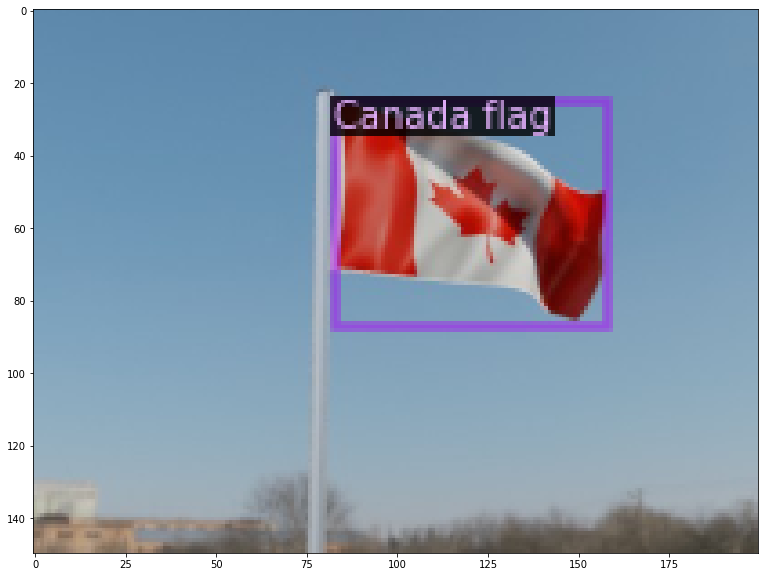

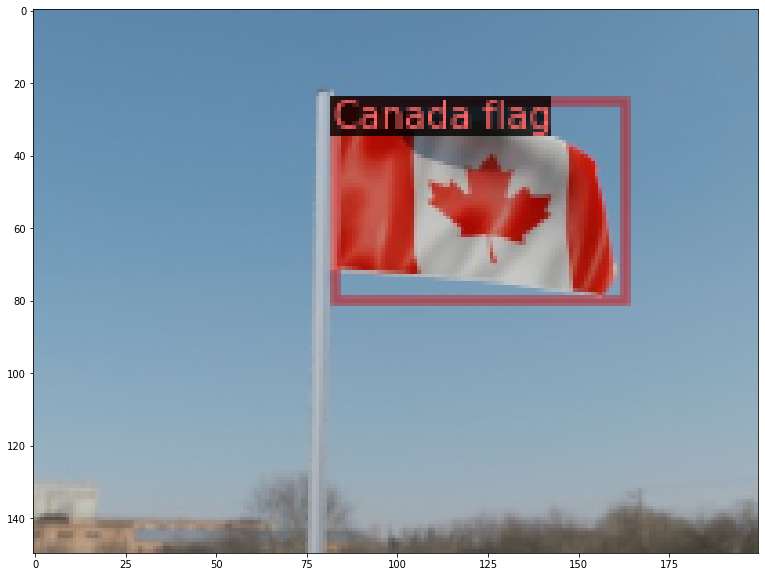

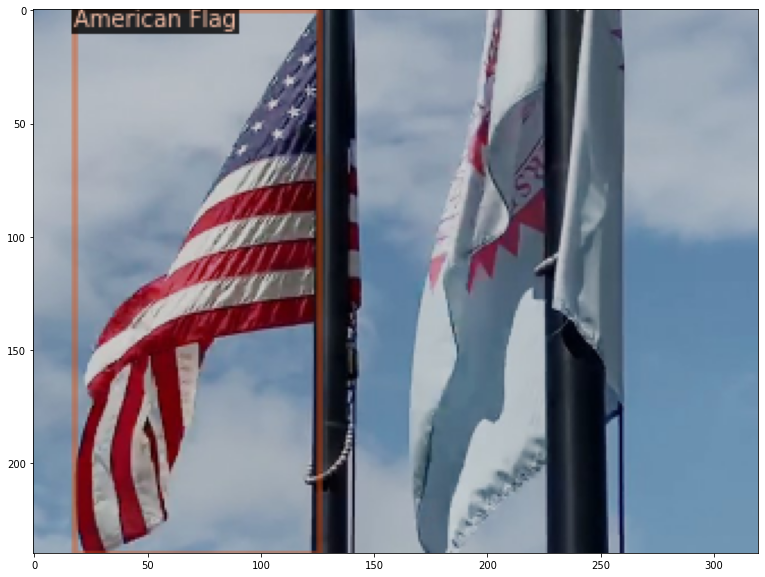

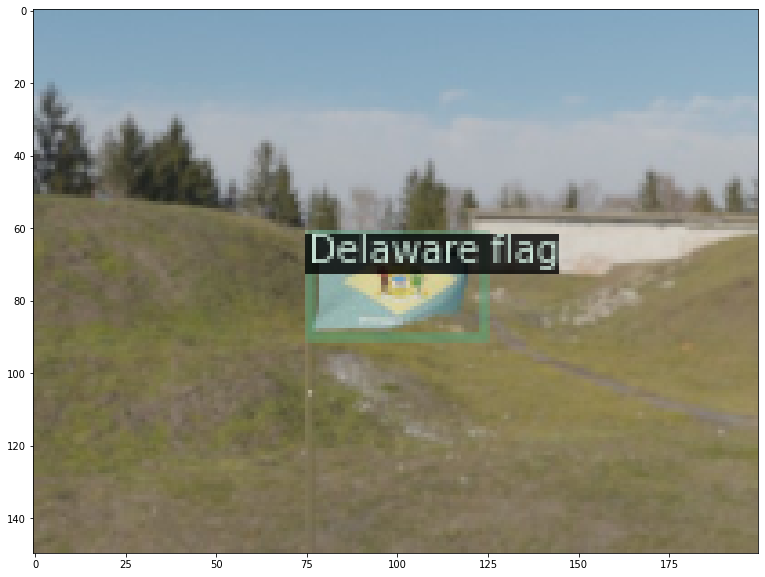

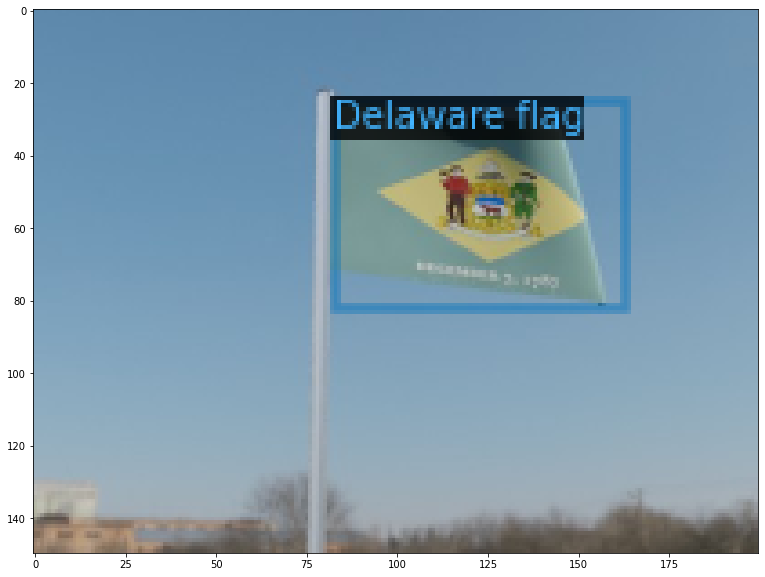

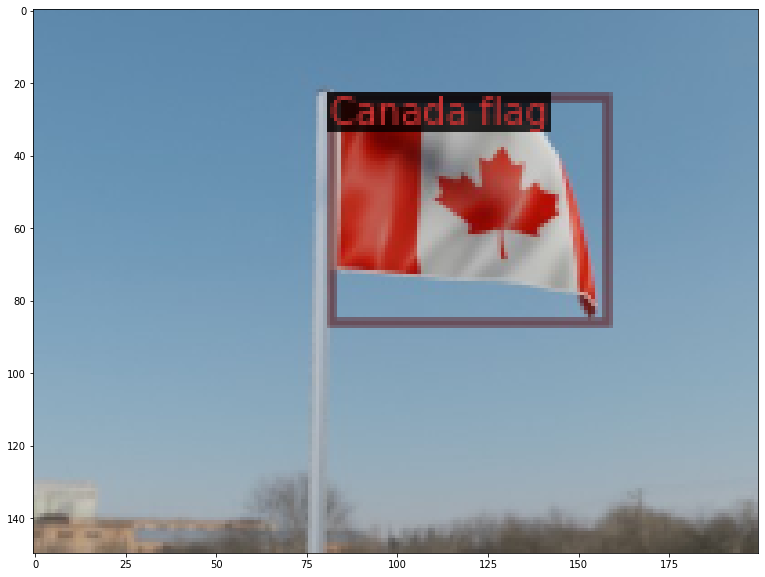

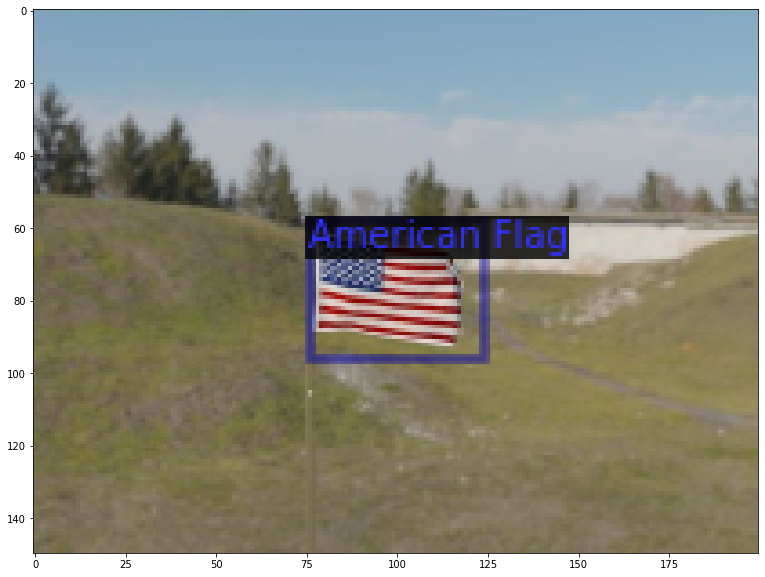

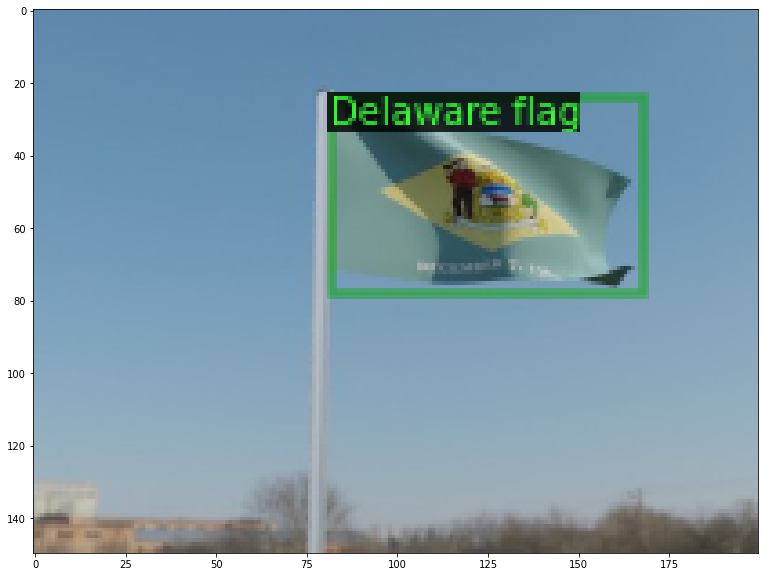

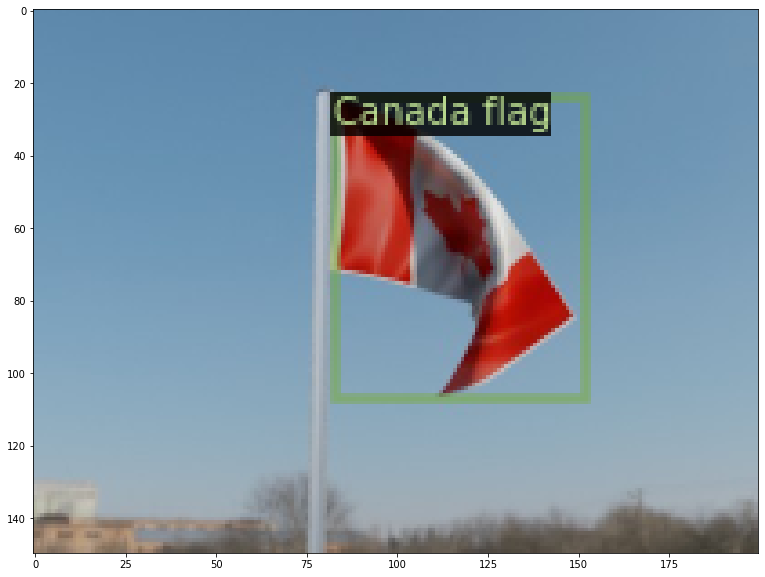

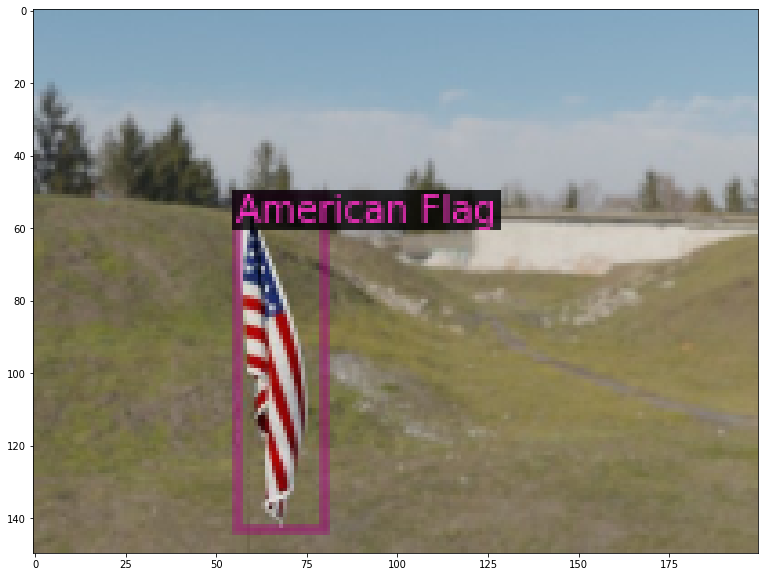

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('flagck1/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=flag_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('flagck1/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/08 16:28:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[10/08 16:28:58 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[10/08 16:29:11 d2.utils.events]:  eta: 0:04:54  iter: 19  total_loss: 0.940  loss_cls: 0.800  loss_box_reg: 0.151  loss_rpn_cls: 0.005  loss_rpn_loc: 0.004  time: 0.6185  data_time: 0.0154  lr: 0.000400  max_mem: 3206M
[10/08 16:29:23 d2.utils.events]:  eta: 0:04:39  iter: 39  total_loss: 0.314  loss_cls: 0.157  loss_box_reg: 0.164  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6201  data_time: 0.0052  lr: 0.000799  max_mem: 3206M
[10/08 16:29:36 d2.utils.events]:  eta: 0:04:30  iter: 59  total_loss: 0.273  loss_cls: 0.109  loss_box_reg: 0.161  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6217  data_time: 0.0056  lr: 0.001199  max_mem: 3206M
[10/08 16:29:48 d2.utils.events]:  eta: 0:04:18  iter: 79  total_loss: 0.270  loss_cls: 0.099  loss_box_reg: 0.169  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6243  data_time: 0.0044  lr: 0.001598  max_mem: 3206M
[10/08 16:30:01 d2.utils.events]:  eta: 0:04:10  iter: 99  total_loss: 0.256  loss_cls: 0.089  loss_box_reg: 0.162  loss

In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('flagck1/test', )
predictor = DefaultPredictor(cfg)

In [33]:
df_test = pd.read_csv('Detectron2//test_labels.csv')
df_test

,filename,width,height,class,xmin,ymin,xmax,ymax
0,0009.jpg,400,300,Canada flag,167,46,337,170
1,0039.jpg,400,300,American Flag,154,121,234,215
2,0144.jpg,400,300,American Flag,146,123,177,214
3,0160.jpg,400,300,Delaware flag,165,46,333,160
4,0185.jpg,400,300,Delaware flag,165,50,321,171
5,0250.jpg,400,300,Canada flag,166,48,336,151
6,0380.jpg,640,480,American Flag,49,48,408,441


In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('flagck1/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=flag_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

from detectron2.utils.visualizer import ColorMode
import random
import os
path = 'nobox'
dirs = os.listdir(path)





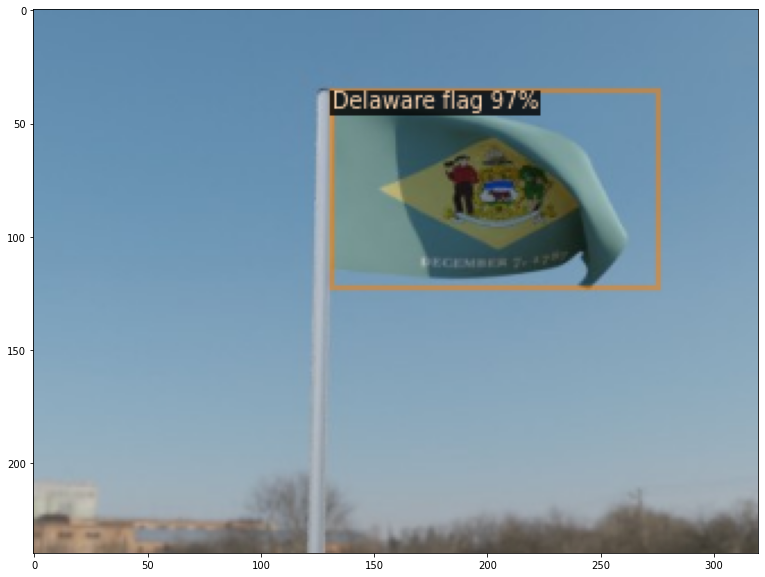

In [105]:
from detectron2.utils.visualizer import ColorMode
import random
path = '0058.jpg'
im = cv2.imread('0058.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=flag_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [103]:
from detectron2.utils.visualizer import ColorMode
import random
import os

path = 'nobox'
dirs = os.listdir(path)

for i in dirs:
  print(i)
  
  outputs = predictor(cv2.imread(i))
  v = Visualizer(im[:, :, ::-1], metadata=flag_metadata, scale=0.8)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize = (14, 10))
  plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
  plt.show()



0110.jpg


AttributeError: ignored